# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://github.com/UBC-CS/cpsc330-2022W2) 

**Due date: Feb 10, 11:59pm**


## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- **Be kind** and respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: 
- `fit` can return nothing, 
- `predict` returns an array whose size is the number of examples, 
- `predict_proba` returns an array whose size is the number of examples x 2, and 
- `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def fit(self, X, y):
        self.total = y.shape[0]
        self.y0 = np.count_nonzero(y == 0)

        return None  # Replace with your code

    def predict(self, X):
        ret = np.zeros(X.shape[0])
        if self.y0 / self.total < 0.5:
            ret += 1
        return ret # Replace with your code

    def predict_proba(self, X):
        y0_prob = self.y0 / self.total
        probs = [y0_prob, 1 - y0_prob]
        return np.array(probs)  # Replace with your code

    def score(self, X, y):
        if self.y0 / self.total > 0.5:
            return np.count_nonzero(y == 0) / y.shape[0]
        return np.count_nonzero(y == 1) / y.shape[0] # Replace with your code

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# Split the data into training and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# Instantiate a CountVectorizer model for Bag of words, uses built-in stop word list for English
countvec = CountVectorizer(stop_words="english")

# Instantiate LogicRegression model with maximum 1000 iterations
lr = LogisticRegression(max_iter=1000)

# Create a pipeline using the CountVectorizer and LogisticRegression models
pipe = make_pipeline(countvec, lr)

# Do 5-fold cross-valiation and put the results into a pandas dataframe
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# find the mean value of the cross-validation results
cross_val_results.mean()


fit_time       0.707558
score_time     0.048323
test_score     0.898444
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. 
    - (Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores.)
- Are the 5 scores close to each other or spread far apart? 
  - (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [11]:
min = cross_val_results["test_score"].min()
max = cross_val_results["test_score"].max()
print(f'The validation score ranges from {min}, {max} which have a difference of {max - min}')
cross_val_results['test_score']

The validation score ranges from 0.8955866523143164, 0.9038757305444478 which have a difference of 0.008289078230131364


0    0.895587
1    0.898047
2    0.896817
3    0.897893
4    0.903876
Name: test_score, dtype: float64

The 5 scores are close together as the max and min validation scores differ by an extremely small amount. (0.008289078230131364)

This data set has 43352 rows compared to the cities dataset with only 209 rows. With a larger dataset, the subscores of each fold would be closer together, as there is more data in each fold allowing the training and validation sets to better generalize patterns and more accurately represent it. With a larger dataset, we can be more sure that cross-validation didn't have good score simply because of luck.

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [12]:
dummy = DummyClassifier()
dummy_cv_results = pd.DataFrame(
    cross_validate(dummy, X_train, y_train, return_train_score=True)
)

dummy_cv_results.mean()

fit_time       0.001230
score_time     0.000278
test_score     0.735314
train_score    0.735314
dtype: float64

The validation score of `DummyClassifier` is much lower than that of our pipeline using `LogisticRegression`. Logistic regression is useful because it computes weights and a bias for the bag of words features learned by `CountVectorizer` allowing it to better predict which words have what kind of influence on the number of retweets.

`CountVectorizer` is not necessary to be used with `DummyClassifier` because `DummyClassifier` uses the `prior` strategy in which it predicts examples to be the target occuring most frequently from training. Therefore, it doesn't consider the features of the training data which are produced by `CountVectorizer`.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [13]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [14]:
# interpreted From Levcture 7
# print(pipe.classes_)
tweet_predict_proba = np.array(pipe.predict_proba(X_test).tolist())

data_dict = {
    "X": X_test,
    "y": y_test,
    "y_hat_False": tweet_predict_proba.T[0].tolist(),
    "y_hat_True": tweet_predict_proba.T[1].tolist(),

}
data_df = pd.DataFrame(data_dict)
highest_prob_viral = data_df.loc[data_df.y_hat_True == data_df['y_hat_True'].max()]
print(f'highest probability of being viral: {highest_prob_viral.iloc[0]["y_hat_True"]}')
print(f'most viral tweet: \n\t{highest_prob_viral.iloc[0]["X"]}')






highest probability of being viral: 0.9999996934381954
most viral tweet: 
	“FBI texts have revealed anti-Trump Bias.” @ FoxNews Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!


The tweet in test set with highest predicted probability is:
> “FBI texts have revealed anti-Trump Bias.” @ FoxNews Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!

With probability `0.9999996934381954`

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [15]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display
- the 5 words with the highest coefficients and 
- the 5 words with the smallest coefficients.

In [16]:
lr_coefs = lr_from_pipe.coef_
lr_coefs_df = pd.DataFrame(data=lr_coefs.T.tolist(), index=vec_from_pipe.get_feature_names(), columns=["Coefficients"])
lr_coefs_df = lr_coefs_df.sort_values(by="Coefficients")

print(lr_coefs_df.head())
print(lr_coefs_df.tail())
  

                 Coefficients
realdonaldtrump     -3.133202
trump2016pic        -2.666855
barackobama         -2.530308
donaldtrump         -2.184535
celebapprentice     -2.106427
             Coefficients
fake             2.483986
mini             2.527120
coronavirus      2.529299
harassment       2.725348
obamagate        2.854125


/Users/kennyjhcheng/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The 5 words with the lowerst coefficients (ranked from lowest to highest) are:
1. realdonaldtrump: `-3.133202`
2. trump2016pic: `-2.666855`
3. barackobama: `-2.530308`
4. donaldtrump: `-2.184535`
5. celebapprentice: `-2.106427`


The 5 words with the highest coefficients are (ranked from higest to lowest) are:
1. fake: `2.483986`
2. mini: `2.527120`
3. coronavirus: `2.529299`
4. harassment: `2.725348`
5. obamagate: `2.854125`

<br><br>

#### 2(f) Running a cross-validation fold without sklearn tools 
rubric={points:8}

Sklearn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. 

**Your tasks:**

1. Compute logistic regression's validation score on the first fold, that is, train on 80% and validate on 20% of the training data (`X_train`) without using sklearn `Pipeline` or `cross_validate` or `cross_val_score`. Store the score of the fold in a variable called `fold_score`. Recall that `cross_validation` in `sklearn` does not shuffle the data by default.    

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split with `train_test_split` and `shuffle=False`):

In [17]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

# split data
X_train_cv, X_valid_cv, y_train_cv, y_valid_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=111, shuffle=False)
# fit and transform feature sets
X_countvec_train = countvec.fit_transform(X_train_cv)
X_countvec_test = countvec.transform(X_valid_cv)

# fit LogisticRegression on training
lr.fit(X_countvec_train, y_train_cv)

fold_score = lr.score(X_countvec_test, y_valid_cv)
fold_score




0.9038905120713517

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. 

Based on the plot/output, what value of `max_features` seems best? Briefly explain.

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

Text(0, 0.5, 'accuracy')

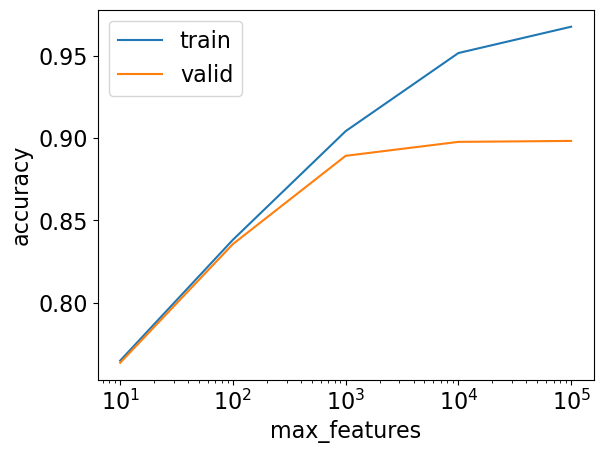

In [18]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy")

In [19]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.764701,0.763425
1,100,0.838270,0.835671
2,1000,0.904380,0.889371
3,10000,0.951936,0.897860
4,100000,0.967952,0.898444


Based on the plot, `max_features = 1000` seems the best because after that point, the divergence of the training and validation scores dramatically increases. Additionally, both the train and validation scores are low and have a small gap before that point. This indicates that `max_features = 1000` is at the boundary after `max_features` values that underfit and before `max_features` values that overfit the model.

<br><br>

#### 3(b)
rubric={points:6}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. 

Based on the plot, what value of `C` seems best?

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

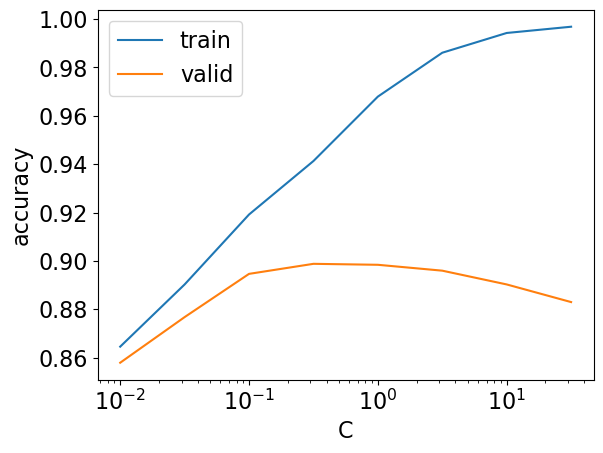

In [20]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [21]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.864612,0.857969
1,0.031623,0.890316,0.876822
2,0.100000,0.919227,0.894692
3,0.316228,0.941333,0.898844
4,1.000000,0.967952,0.898444
5,3.162278,0.986091,0.896014
6,10.000000,0.994256,0.890324
7,31.622777,0.996840,0.883035


Based on the plot, `C = 10^-1` seems the best because for the next value `C=10^-0.5`, the training score increases, while the validation score barely does. 

Additionally, this indicates that at `C = 10^-1`, values of `C` after that will tend to overfit the model by having high training scores but low validation scores. Before `C = 10^-1`, the values of `C` may be underfitting because increasing `C` has a positive effect on both train and validation scores, indicating that the low `C` value may be missing some patterns.

<br><br>

#### 3(c) Hyperparameter optimization 
rubric={points:10}

Start with the pipeline `pipe` below.

**Your tasks:**
- Create a `GridSearchCV` object named `grid_search` to jointly optimize `max_features` of `CountVectorizer` and `C` of `LogisticRegression` across all the combinations of values we tried above. 
- What are the best values of `max_features` and `C` according to your grid search? 
- Store them in variables `best_max_features` and `best_C`, respectively.  
- Store the best score returned by the grid search in a variable called `best_score`. 

> The code might be a bit slow here. Setting `n_jobs=-1` should speed it up if you have a multi-core processor.

In [22]:
pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, random_state=123))

param_grid = {
    "countvectorizer__max_features": [10, 100, 1000, 10_000, 100_000],
    "logisticregression__C": 10.0 ** np.arange(-2, 2, 0.5),
}


grid_search = GridSearchCV(
    pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=123))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01])},
             return_train_score=True)

In [23]:
best = grid_search.best_params_
best_max_features = best['countvectorizer__max_features']
best_C = best['logisticregression__C']
best_score = grid_search.best_score_

print(f'The max_features for CountVectorizer is: {best_max_features}')
print(f'The C for LogisticRegression is: {best_C}')
print(f'The best validation score is: {best_score}')

The max_features for CountVectorizer is: 100000
The C for LogisticRegression is: 0.31622776601683794
The best validation score is: 0.8988437251093868


In [24]:
print(pd.DataFrame(grid_search.cv_results_).columns)

pd.DataFrame(grid_search.cv_results_)[
  [
    "mean_test_score",
    "mean_train_score",
    "param_countvectorizer__max_features",
    "param_logisticregression__C",
    "rank_test_score",
  ]
].set_index("rank_test_score").sort_values("mean_test_score", ascending=False).T

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_countvectorizer__max_features', 'param_logisticregression__C',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


rank_test_score,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,34,34,37,37,39,40
mean_test_score,0.898844,0.898505,0.898475,0.89786,0.896014,0.894692,0.894384,0.8926,0.890355,0.889371,...,0.833579,0.816633,0.763579,0.763456,0.763456,0.763456,0.763425,0.763425,0.763425,0.747647
mean_train_score,0.941333,0.933367,0.967952,0.951936,0.986091,0.919227,0.914883,0.966668,0.994256,0.90438,...,0.835463,0.81754,0.764794,0.764724,0.764724,0.764678,0.764701,0.764701,0.763548,0.74734
param_countvectorizer__max_features,100000,10000,100000,10000,100000,100000,10000,10000,100000,1000,...,100,100,10,10,10,10,10,10,10,10
param_logisticregression__C,0.316228,0.316228,1.0,1.0,3.162278,0.1,0.1,3.162278,10.0,1.0,...,0.031623,0.01,0.1,31.622777,10.0,0.316228,3.162278,1.0,0.031623,0.01


<br><br>

#### 3(d) Discussion 
rubric={points:4}

- Do the best values of hyperparameters found by Grid Search agree with what you found in 3(a) and 3(b)? 
- **Generally speaking**, _should_ these values agree with what you found in parts  3.1 and 3.2? Why or why not? 

The "best" hyperparameters found by Grid Search do not agree with my results from 3(a) and 3(b).

Generally, these values should not agree with what you found by optimizing these parameters individually. This is because the validation scores of one hyperparameter may differ depending on variations in another hyperparameter. 

This can be seen in the heatmap visualization. If we were only optimizing `C`, depending on what our `max_features` constant value is, our optimal `C` may be different.

Similarly, if we were only optimizing `max_features`, the constant value `C` we choose would influence which "best" `max_features` we choose.

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, '10'),
  Text(1.5, 0, '100'),
  Text(2.5, 0, '1000'),
  Text(3.5, 0, '10000'),
  Text(4.5, 0, '100000')])

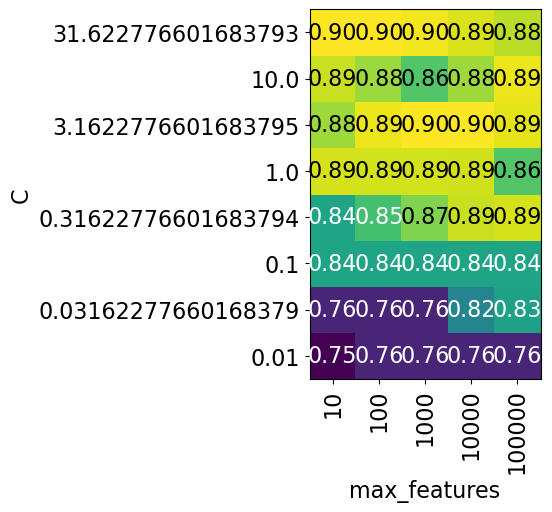

In [25]:
# adapted from lecture 8
# display_heatmap(param_grid, pipe, X_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(8, 5)

# plot the mean cross-validation scores
mglearn.tools.heatmap(
    scores,
    xlabel="max_features",
    xticklabels=param_grid["countvectorizer__max_features"],
    ylabel="C",
    yticklabels=param_grid["logisticregression__C"],
    cmap="viridis",
)
plt.xticks(rotation=90)


#### 3(e) Test score
rubric={points:2}

- Evaluate your final model on the test set. Store the test accuracy in the variable called `test_score`.

In [26]:
test_score = grid_search.score(X_test, y_test)
test_score

0.9018269053330873

#### 3(f) Discussion of Test Score
rubric={points:4}

- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [27]:
print(f"The test score is: {test_score}\nThe validation score is: {best_score}")
print(f"The difference between the test and validation score is {best_score - test_score}")

The test score is: 0.9018269053330873
The validation score is: 0.8988437251093868
The difference between the test and validation score is -0.0029831802237004768


The test accuracy is very similar to the validation accuracy. And they are both high. Although the test accuracy is higher than the validation accuracy which is unexpected.

The test accuracy being higher than the validation accuracy may be due to random luck since the difference is extremely small and may not be significant. Also, this may be due to overfitting on the validation set due to it being not large enough, therefore by luck, one of the models had a low validation error by chance which is unrepresentative and doesn't generalize well.

## Exercise 4: Very short answer questions
rubric={points:8}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
3. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?
4. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?

1. using `fit_transform` on your **test** data with `CountVectorizer` is violating the golden rule because the test data is fitting the transformer
    > test data cannot influence training phase in any way
2. I would access `predict_proba` because it gives me more information. I can obtain the same information as `predict` by simply looking at which prediction has the highest accuracy, additionally I can see the model's confidence with given predictions.

3. Two advantages are:
    * `RandomizedSearchCV` is faster than `GridSearchCV` because it doesn't brute force search through all possible combinations of hyperparameters given. Searches in the `GridSearchCV` may be redundantly trying combinations of unimportant parameters providing no new information.
    * Adding hyperparameters doesn't influence the efficiency of `RandomizedSearchCV` because the number of iterations is decided by the `n_iter` parameter rather than all combinations of possible hyperparameters values.
4. It is important to follow the Golden Rule because if the test data influences the classifier, then you cannot properly evaluate the classifier on new data. The patterns identified by the classifier overfit the test data. It is analogous to knowing the answers to a test before writing it, the test no longer becomes a proper evaluation of a students understanding of the material.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 